## Visualize scores for other cell line clones

In this analysis module, we trained a multiclass classifier to predict two bortezomib resistant clones from a wild-type parental cell line. We applied the model to other clones collected on a separate plate and batch. In this notebook, we visualize the resulting predictions.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
scores <- list()

batch <- "2019_11_20_Batch6"
plate <- "217762"

models <- c("real", "shuffled")

for (model in models) {
    file <- file.path(
        "scores", paste0(batch, "_", plate, "_", model, "_model_othersinglecells.tsv.gz")
    )
    scores[[model]] <- readr::read_tsv(file, col_types = readr::cols())
}


In [3]:
real_df <- scores[["real"]] %>%
    reshape2::melt(
        measure.vars = c("WT parental", "Clone A", "Clone E"),
        variable.name = "model",
        value.name = "probability"
    )

shuffle_df <- scores[["shuffled"]] %>%
    reshape2::melt(
        measure.vars = c("WT parental", "Clone A", "Clone E"),
        variable.name = "model",
        value.name = "probability"
    )

df <- dplyr::bind_rows(real_df, shuffle_df)

df$Metadata_treatment <- factor(df$Metadata_treatment, levels = c("DMSO", "bortezomib"))

head(df, 3)

,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,data_fit,shuffled,model,probability
,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<fct>,<chr>,<chr>,<fct>,<dbl>
1,2.051143e+38,1861,217762,B02,217762,BZ017,217762,20191120-20191115-LoDensity,DMSO,other_batch,False,WT parental,0.07259028
2,2.051143e+38,1861,217762,B02,217762,BZ017,217762,20191120-20191115-LoDensity,DMSO,other_batch,False,WT parental,0.17015602
3,2.051143e+38,1861,217762,B02,217762,BZ017,217762,20191120-20191115-LoDensity,DMSO,other_batch,False,WT parental,0.35917927


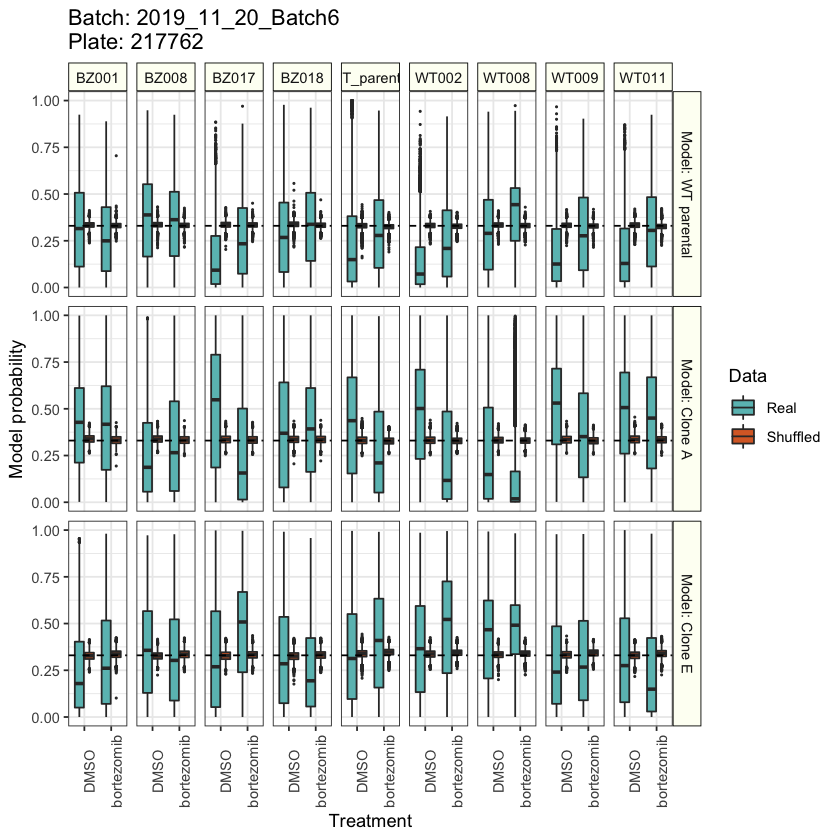

In [4]:
append_model <- function(string) paste0("Model: ", string)

ggplot(df, aes(x = factor(Metadata_treatment), y = probability, fill = shuffled)) +
    geom_boxplot(outlier.size = 0.2) +
    facet_grid("model~Metadata_clone_number",
               labeller = labeller(model = as_labeller(append_model))) +
    xlab("Treatment") +
    ylab("Model probability") +
    ggtitle(paste0("Batch: ", batch, "\nPlate: ", plate)) +
    scale_fill_manual(name = "Data",
                      labels = c("True" = "Shuffled", "False" = "Real"),
                      values = c("True" = "#D96A2F", "False" = "#6ABEBE")) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 90),
        strip.background = element_rect(colour = "black", fill = "#fdfff4")
    ) +
    geom_hline(yintercept = 0.33, linetype = "dashed", color = "black")

output_fig <- file.path(
    "figures", "predictions", paste0(batch, "_", plate, "_predictions_boxplot.png")
    )
ggsave(output_fig, dpi = 500, height = 6, width = 9.5)